# PyTorch Layer 이해하기
## 예제 불러오기

In [1]:
import torch

from torchvision import datasets, transforms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("dataset", train=True, download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                  ])),
    batch_size=1)

In [4]:
image, label = next(iter(train_loader))

In [5]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

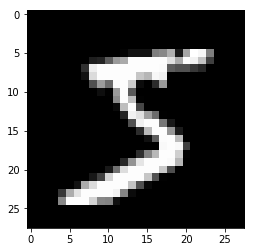

In [6]:
plt.imshow(image[0, 0, :, :], "gray")
plt.show()

# 각 Layer별 설명
- Network 쌓기 위한 준비

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Convolution
- in_channels : 받게 될 channel의 갯수
- out_channels : 보내고 싶은 channel의 갯수
- kernel_size : 만들고 싶은 kernel(weights)의 사이즈

In [8]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [20]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device("cuda"))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [21]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 있음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [23]:
weight = weight.detach().cpu().numpy()

In [13]:
weight.shape

(20, 1, 5, 5)

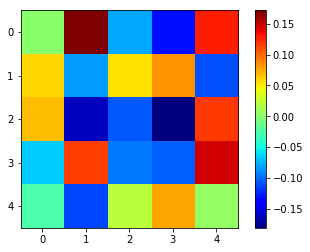

In [14]:
plt.imshow(weight[0, 0, :, :], "jet")
plt.colorbar()
plt.show()

- output 시각화 준비를 위해 numpy화

In [25]:
output_data = layer(image)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [26]:
output_data = output_data.data

In [28]:
output = output_data.cpu().numpy()

In [29]:
output.shape

(1, 20, 24, 24)

- Input으로 들어간 이미지 numpy화

In [31]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

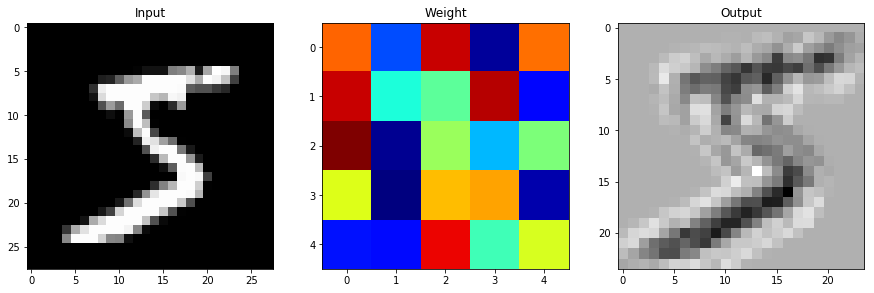

In [33]:
plt.figure(figsize=(15, 30))
plt.subplot(131)
plt.title("Input")
plt.imshow(np.squeeze(image_arr), "gray")

plt.subplot(132)
plt.title("Weight")
plt.imshow(weight[0, 0, :, :], "jet")
plt.subplot(133)

plt.title("Output")
plt.imshow(output[0, 0, :, :], "gray")
plt.show()

### Pooling
input을 먼저 앞에 넣고, 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [34]:
image.shape

torch.Size([1, 1, 28, 28])

In [35]:
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPool Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [38]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [39]:
image_arr.shape

(1, 1, 28, 28)

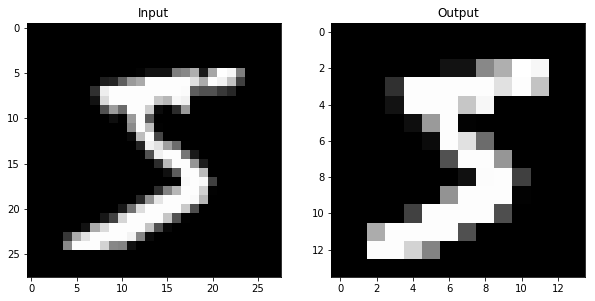

In [40]:
plt.figure(figsize=(10, 15))
plt.subplot(121)
plt.title("Input")
plt.imshow(np.squeeze(image_arr), "gray")

plt.subplot(122)
plt.title("Output")
plt.imshow(np.squeeze(pool_arr), "gray")
plt.show()

### Linear
nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼춰줘야함

In [41]:
image.shape

torch.Size([1, 1, 28, 28])

In [42]:
flatten = image.view(1, 28*28)
flatten.shape

torch.Size([1, 784])

In [44]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [45]:
lin

tensor([[-0.0074,  0.1881, -0.3502,  0.2226, -0.0730,  0.0161, -0.0735,  0.1153,
         -0.1441,  0.4375]], grad_fn=<AddmmBackward>)

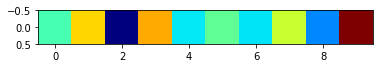

In [46]:
plt.imshow(lin.detach().numpy(), "jet")
plt.show()

### Softmax
결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 weight를 꺼줘야함

In [47]:
with torch.no_grad():
    flatten = image.view(1, 28 * 28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1)

In [48]:
softmax

tensor([[0.0713, 0.1040, 0.1010, 0.1184, 0.0927, 0.0950, 0.1319, 0.1238, 0.0925,
         0.0694]])

In [49]:
np.sum(softmax.numpy())

1.0